In [1]:
import sys
import time
import numpy as np
import os.path as osp
import tensorflow as tf
import matplotlib.pyplot as plt

from tf_lab.fundamentals.utils import set_visible_GPUs, reset_tf_graph

import tf_lab.point_clouds.in_out as pio
from tf_lab.point_clouds.in_out import PointCloudDataSet, write_model_ids_of_datasets
from tf_lab.point_clouds.point_net_ae import PointNetAutoEncoder
from tf_lab.point_clouds.autoencoder import Configuration as Conf
import tf_lab.point_clouds.encoders_decoders as enc_dec

from tf_lab.autopredictors.evaluate.basics import eval_model, read_saved_epochs
from tf_lab.autopredictors.scripts.helper import shape_net_category_to_synth_id, match_incomplete_to_complete_data
from tf_lab.autopredictors.plotting.basics import plot_original_pclouds_vs_reconstructed,\
                                                  plot_train_val_test_curves, plot_reconstructions_at_epoch




from general_tools.in_out.basics import create_dir, delete_files_in_directory, files_in_subdirs
from geo_tool import Point_Cloud

/orions4-zfs/projects/lins2/Panos_Space/Git_Repos/geo_tool/solids/mesh.py:26: UserWarning: Mayavi library was not found. Some graphics utilities will be disabled.
  warnings.warn('Mayavi library was not found. Some graphics utilities will be disabled.')


In [2]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [10]:
seed = 42
np.random.seed(seed)
tf.set_random_seed(seed)

class_type = raw_input('Give me the class type.\n').lower()
class_syn_id = shape_net_category_to_synth_id()[class_type]

top_data_dir = '/orions4-zfs/projects/lins2/Panos_Space/DATA/'
full_pclouds_path = osp.join(top_data_dir, 'ShapeNetPointClouds/from_manifold_meshes/1024/', class_syn_id)


experiment_name = 'blensor_' + class_syn_id + '_only_ae_test_Delete'
train_dir = osp.join(top_data_dir, 'OUT/models/incomplete_pclouds/', experiment_name)

create_dir(train_dir)

Give me the class type.
chair


'/orions4-zfs/projects/lins2/Panos_Space/DATA/OUT/models/incomplete_pclouds/blensor_03001627_only_ae_test_Delete'

## Load Original Pclouds and inclomplete from Blensor

In [4]:
full_file_names = pio.load_filenames_of_input_data(full_pclouds_path)
full_pclouds, full_model_names, class_ids = pio.load_crude_point_clouds(file_names=full_file_names, n_threads=11)
print '%d files containing complete point clouds were found.' % (len(full_pclouds), )

6778 files containing complete point clouds were found.


In [5]:
blensor_data = osp.join(top_data_dir, 'Blensor_Incomplete_Pclouds/', class_syn_id)
noisy_pcloud_files = pio.load_filenames_of_input_data(blensor_data, pio.blensor_search_pattern)

noisy_pclouds, noisy_model_names, class_ids = pio.load_crude_point_clouds(file_names=noisy_pcloud_files, 
                                                                n_threads=11, 
                                                                loader=pio._load_blensor_incomplete_pcloud)


print '%d files containing noisy point clouds were found.' % (len(noisy_pclouds), )

3738 files containing noisy point clouds were found.


In [6]:
mapping = match_incomplete_to_complete_data(full_model_names, noisy_model_names)
full_pclouds_matched = full_pclouds[mapping]

In [7]:
train_data_, _, test_data_, _ = pio.train_validate_test_split([full_pclouds_matched,
                                                            noisy_pclouds, 
                                                            noisy_model_names],
                                                            train_perc=0.9,
                                                            validate_perc=0.0,
                                                            test_perc=0.1,
                                                            seed=seed)

train_data = PointCloudDataSet(train_data_[0], noise=train_data_[1], labels=train_data_[2])
test_data = PointCloudDataSet(test_data_[0], noise=test_data_[1], labels=test_data_[2])

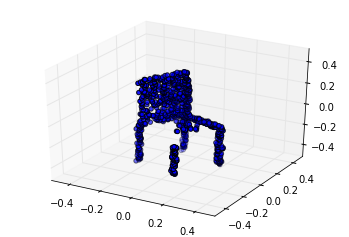

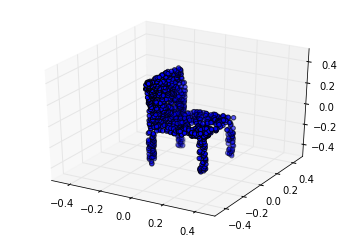

In [8]:
# TRY ME just to verify the models match.
pp = test_data.next_batch(1)
Point_Cloud(points=pp[2].reshape(1024, 3)).plot(in_u_sphere=True);
Point_Cloud(points=pp[0].reshape(1024, 3)).plot(in_u_sphere=True);

In [ ]:
n_input = [1024, 3]

# decoder_args = {'layer_sizes': [1024, np.prod(n_input)], 
#                 'non_linearity': tf.nn.tanh
#                }

encoder_args = {'spn': False}
 
conf = Conf(
            n_input = n_input,
            training_epochs = 1000,
            batch_size = 40,
            loss = 'chamfer',
            train_dir = train_dir,
            loss_display_step = 1,
            saver_step = 10,
            learning_rate = 0.00002,
            saver_max_to_keep = 100,
            gauss_augment = {'mu': 0, 'sigma': 0.02},            
            encoder = enc_dec.encoder_with_convs_and_symmetry,
            decoder = enc_dec.complex_decoder,
            decoder_args = decoder_args,
            encoder_args = encoder_args,
            denoising = True
           )

conf.experiment_name = experiment_name
conf.save(osp.join(conf.train_dir, 'configuration'))


reset_tf_graph()
set_visible_GPUs([2])
ae = PointNetAutoEncoder(experiment_name, conf)

do_training = True

if do_training:
    ae.train(train_data, conf)

else:
    saved_epochs = read_saved_epochs(conf.train_dir)
    ae.restore_model(train_dir, saved_epochs[-1])
    

Tensor("blensor_03001627_only_ae_test_Delete/Placeholder:0", shape=(?, 1024, 3), dtype=float32)
('Epoch:', '0001', 'training time (minutes)=', '0.3244', 'loss=', '0.058878451')
('Epoch:', '0002', 'training time (minutes)=', '0.3215', 'loss=', '0.014039819')
('Epoch:', '0003', 'training time (minutes)=', '0.3210', 'loss=', '0.005088272')
('Epoch:', '0004', 'training time (minutes)=', '0.3438', 'loss=', '0.004309278')

In [11]:
ae.train(train_data, conf)

Model restored in epoch 155.


# Evaluation

In [28]:
saved_epochs = read_saved_epochs(conf.train_dir)
epochs = saved_epochs[::len(saved_epochs)/20]
stats = eval_model(ae, conf, [train, test_data], epochs=epochs, verbose=True)

Model restored in epoch 5.
[ 0.00324708]
Model restored in epoch 60.
[ 0.00243782]
Model restored in epoch 115.
[ 0.00221188]
Model restored in epoch 170.
[ 0.00216206]
Model restored in epoch 225.
[ 0.00211457]
Model restored in epoch 280.
[ 0.00204853]
Model restored in epoch 335.
[ 0.00209138]
Model restored in epoch 390.
[ 0.0020633]
Model restored in epoch 445.
[ 0.00207429]
Model restored in epoch 500.
[ 0.00209186]
Model restored in epoch 555.
[ 0.00209509]
Model restored in epoch 610.
[ 0.00210001]
Model restored in epoch 665.
[ 0.00206721]
Model restored in epoch 720.
[ 0.00210531]
Model restored in epoch 775.
[ 0.00209251]
Model restored in epoch 830.
[ 0.00208099]
Model restored in epoch 885.
[ 0.00212812]
Model restored in epoch 940.
[ 0.00212241]
Model restored in epoch 995.
[ 0.00209849]
Model restored in epoch 1050.
[ 0.00211151]
Model restored in epoch 1105.
[ 0.00211416]


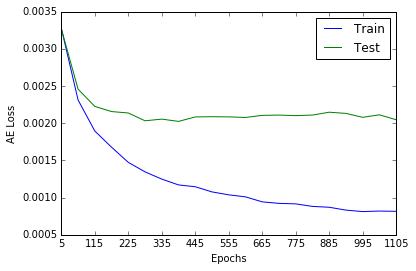

In [26]:
top_save_dir = osp.join(top_data_dir, 'OUT/model_evaluation/incomplete_pclouds/', experiment_name)
plot_train_val_test_curves(stats, top_save_dir, has_validation=False, best_epoch=None, show=True)

In [27]:
last_epoch = saved_epochs[-1]
save_dir = osp.join(top_save_dir, 'train_images_epoch_' + str(last_epoch))
plot_reconstructions_at_epoch(last_epoch, ae, train_data, conf, save_dir=save_dir, max_plot=100)

save_dir = osp.join(top_save_dir, 'test_images_epoch_' + str(last_epoch))
plot_reconstructions_at_epoch(last_epoch, ae, test_data, conf, save_dir=save_dir, max_plot=100)